In [3]:
%load_ext line_profiler

In [4]:
import jax.numpy as np
import matplotlib.pyplot as plt
from numpy.random import seed as set_seed, randint
from scipy import stats
from jax.interpreters.xla import DeviceArray
from jax import grad, jit

plt.style.use('seaborn-darkgrid')
plt.rcParams['image.cmap'] = 'Dark2'
plt.rcParams['figure.figsize'] = [9.0, 6.0]

# Definitions

In [5]:
def classify_with_hyperplane(X, w) -> '(X.shape[0],)':
    return np.sign(X @ w)

# def classify_with_tiles(X, B, c) -> '(X.shape[0],)':
#     tiles = (X[:, :, np.newaxis] > B[np.newaxis, :, :]).sum(axis=2)
#     tiles_flat = tiles @ np.array([(k+1)**i for i in range(d)])
#     return c[tiles_flat]

def plot_2d_problem(X, y=None, B=None, RX=None):
    x = np.linspace(X.min(), X.max(), 100)
    plt.scatter(*X.T, c=y, alpha=0.25)
    plt.plot(x, x, 'k--', alpha=0.15)
    if B is not None:
        plt.vlines(B[0], X[:, 1].min(), X[:, 1].max(),
                   colors='k', linestyles='dashed')
        plt.hlines(B[1], X[:, 0].min(), X[:, 0].max(),
                   colors='k', linestyles='dashed')
        
    if RX is not None:
        plt.scatter(*RX.T, s=100, marker='X', c='black')

def sigmoid(x) -> 'x.shape':
    return 1/(1 + np.exp(-x))

def make_normal_unit_vector(d) -> '(d,)':
    v = np.append(-1, np.ones(d-1))
    return v/np.sqrt(v@v)

def add_seperation(X, sep=0) -> 'X: (N, d); y: (N,)':
    d = X.shape[1]
    w = make_normal_unit_vector(d)
    y = np.sign(X @ w)
    X += sep*y[:, np.newaxis]*w
    return X, y

# def generate_random_boundaries(X, d, k) -> '(d, k)':
#     dist = stats.uniform(loc=X.min(), scale=X.max() - X.min())
#     sample = lambda: np.array(dist.rvs(size=(1, k))).sort()
#     return np.concatenate([sample() for _ in range(d)])

def generate_random_reconstruction_points(X, M, d) -> '(M, d)':
    dist = stats.uniform(loc=X.min(), scale=X.max() - X.min())
    return dist.rvs(size=(M, d))

# def plot_2d_problem(X, y=None, B=None, RX=None):
#     x = np.linspace(X.min(), X.max(), 100)
#     plt.scatter(*X.T, c=y, alpha=0.25)
#     plt.plot(x, x, 'k--', alpha=0.15)
#     if B is not None:
#         plt.vlines(B[0], X[:, 1].min(), X[:, 1].max(),
#                    colors='k', linestyles='dashed')
#         plt.hlines(B[1], X[:, 0].min(), X[:, 0].max(),
#                    colors='k', linestyles='dashed')
        
#     if RX is not None:
#         plt.scatter(*RX.T, s=100, marker='X', c='black')
    
# def calc_tile_centroids(B, X) -> '(M, d)':
#     B_ = np.hstack([X.min(axis=0)[:, np.newaxis],
#                     B,
#                     X.max(axis=0)[:, np.newaxis]])
#     RX = (B_[:, :-1] + B_[:, 1:])/2
#     return np.stack(np.meshgrid(*RX), axis=-1).reshape(-1, X.shape[1])

# def calc_min_reconstruction_tiling(RX) -> '(M, d)':
#     d = RX.shape[1]
#     R = int(np.log2(RX.shape[0])/d)
#     Z_coords = sort_dimensions(RX).reshape(2**R, -1, d).mean(axis=1).T
#     return np.stack(np.meshgrid(*Z_coords), axis=2).reshape(-1, d), Z_coords

# def calc_boundaries_from_tile_centroids(Z_coords) -> '(d, k)':
#     return (Z_coords[:, 1:] + Z_coords[:, :-1])/2

# def sort_dimensions(A) -> '(*A.shape)':
#     return A[A.argsort(axis=0), np.arange(A.shape[1])]

# def find_closest_rpoints_index(X, Z) -> '(N,)':
#     return np.power(X[:, np.newaxis] - Z, 2).sum(axis=2).argmin(axis=1)

# # def calc_best_rpoints(X, Qinv, RX=None) -> '(M, d)':
# #     if RX is not None:
# #         X = np.concatenate((X, RX), axis=0)
# #         Qinv = np.concatenate((Qinv, np.arange(RX.shape[0])))
# #     count_per_region = np.unique(Qinv, return_counts=True)[1]
# #     tiled_points = np.split(X[Qinv.argsort()], count_per_region.cumsum()[:-1])
# #     return np.array([region.mean(axis=0) for region in tiled_points])

def calc_best_rpoints(X, Qinv, RX=None) -> '(M, d)':
    if RX is not None:
        X = np.concatenate((X, RX), axis=0)
        Qinv = np.concatenate((Qinv, np.arange(RX.shape[0])))
    return np.array([X[Qinv == i].mean(axis=0) for i in range(M)])


def calc_optimal_reconstruction_points(Q, X, M) -> '(M, d)':
    Q_flat = ((Q @ flattener)[:, np.newaxis] + aux1).ravel('F')
    avgs = np.bincount(Q_flat, weights=X.ravel('F'))/np.bincount(Q_flat)
    return avgs.reshape((M, -1), order='F')


def calc_distortion(X, Q, RX):
    return ((X - RX[Q @ flattener])**2).sum(axis=1).mean()

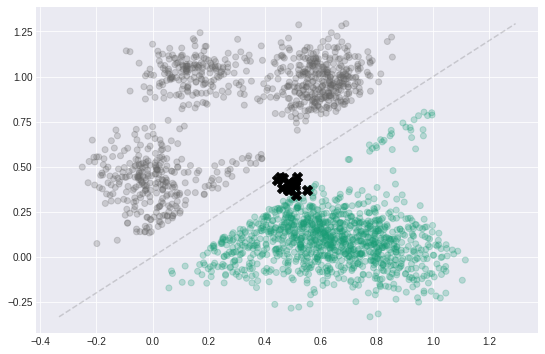

In [49]:
seed: 'global numpy seed' = 733
set_seed(seed)

N: 'sample size' = 2_000
d: 'problem dimension' = 2
R: 'bit rate per dimension' = 2
k: 'number of boundaries (roots) per dimension' = 2**R - 1
X: 'sample' = (stats
               .multivariate_normal(mean=stats.uniform().rvs(10*d),
                                    cov=1e-2)
               .rvs(size=int(N/10))
               .reshape(-1, d))
# X = stats.uniform().rvs((N, d))

X, y = add_seperation(X, 0.1)
w: 'unit vector normal to class. boundary (d,)' = make_normal_unit_vector(d)
M: 'number of reconstruction points' = 2**(R*d)
# RX: 'reconstruction points' = generate_random_reconstruction_points(X, M, d)
Q: 'quantization indices' = np.array(stats.randint(0, 2**R).rvs((N, d)))
flattener: 'vector that flattens the quantion indices with Q @ flattener' = np.array([2**(R*i) for i in range(d)])
aux1 = np.array([i*M for i in range(d)])[np.newaxis]

if d == 2:
    RX = calc_optimal_reconstruction_points(Q, X, M)
    plot_2d_problem(X, y, RX=RX)
    plt.show()

# Distortion-only Optimal Quantizer Design (no side-information)

In [50]:
def calc_optimal_quantization_indices(RX, X):
    pass

# Q = calc_optimal_quantization_indices(RX, X)
# RX = calc_optimal_reconstruction_points(Q, X, M)
# plot_2d_problem(X, y, B, RX)

In [51]:
aux2 = np.arange(2**R).tile((N, d, 1)).swapaxes(1, 2)
aux2.shape

(2000, 4, 2)

In [84]:
Q.tile((2**R, 1, 1)).swapaxes(0, 2).swapaxes(0, 1).shape

(2000, 2, 4)

In [44]:
aux2[0][:, :, np.newaxis]

DeviceArray([[[0],
              [0]],

             [[1],
              [1]],

             [[2],
              [2]],

             [[3],
              [3]]], dtype=int32)

# References
1. https://web.stanford.edu/~bgirod/pdfs/RebolloDCC03.pdf
2. https://jakevdp.github.io/blog/2017/03/22/group-by-from-scratch/